In [1]:
import rebound
import reboundx
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import math
plt.style.use('paper')

In [2]:
Mp = 1.e-8
def makesim(e=0.01, dtOverT = 0.01):
    sim = rebound.Simulation()
    sim.G = 4*np.pi**2
    sim.add(m=1.)
    sim.add(m=Mp, P=1., e=e)
    sim.move_to_com()
    sim.dt = dtOverT*sim.particles[1].P

    return sim

In [3]:
alpha = (7./40.)**0.5
beta = 1/48./alpha

def X(sim, kepler, damp, a, b, h):
    kepler.step(sim, -a*h)
    damp.step(sim, b*h)
    kepler.step(sim, a*h)
    return sim

def Z(sim, kepler, damp, a, b, h):
    sim = X(sim, kepler, damp, -a, -b, h)
    sim = X(sim, kepler, damp, a, b, h)
    return sim

def corrector3(sim, kepler, damp, h):
    a1 = -alpha
    a2 = alpha
    b2 = beta/2.
    b1 = -beta/2.
    
    sim = Z(sim, kepler, damp, a2, b2, h)
    sim = Z(sim, kepler, damp, a1, b1, h)
    return sim 

def corrector3inv(sim, kepler, damp, h):
    a1 = -alpha
    a2 = alpha
    b2 = beta/2.
    b1 = -beta/2.
    
    sim = Z(sim, kepler, damp, a1, -b1, h)
    sim = Z(sim, kepler, damp, a2, -b2, h)
    return sim


In [4]:
%%time
Nout = 1000
e=0.1
dtOverT = 0.001
taua = 1000
tmax = 3*taua

times = np.linspace(0, tmax, Nout)

simKD = makesim(e=e, dtOverT=dtOverT)
rebxKD = reboundx.Extras(simKD)
modKD = rebxKD.load_force("modify_orbits_forces")
rebxKD.add_force(modKD)

simKD.integrator = "none"
keplerKD = rebxKD.load_operator("kepler")
integforceKD = rebxKD.load_operator("integrate_force")
integforceKD.params['force'] = modKD
integforceKD.params['integrator'] = reboundx.integrators["rk4"]
rebxKD.add_operator(keplerKD, dt_fraction=0.5, timing="post")
rebxKD.add_operator(integforceKD, dt_fraction=1., timing="post")
rebxKD.add_operator(keplerKD, dt_fraction=0.5, timing="post")
simKD.particles[1].params['tau_a'] = -taua

sim = makesim(e=e, dtOverT=dtOverT)
sim.integrator = "ias15"
rebx = reboundx.Extras(sim)
mod = rebx.load_force("modify_orbits_forces")
rebx.add_force(mod)
sim.particles[1].params['tau_a'] = -taua

EsKD, Es = np.zeros(Nout), np.zeros(Nout)
P = np.zeros(Nout)

for i, time in enumerate(times):
    simKD.integrate(time, exact_finish_time=0)
    sim.integrate(simKD.steps_done*simKD.dt)
    
    Es[i] = sim.calculate_energy()
    EsKD[i] = simKD.calculate_energy()
    P[i] = sim.particles[1].P

CPU times: user 51 s, sys: 11.3 ms, total: 51 s
Wall time: 51 s


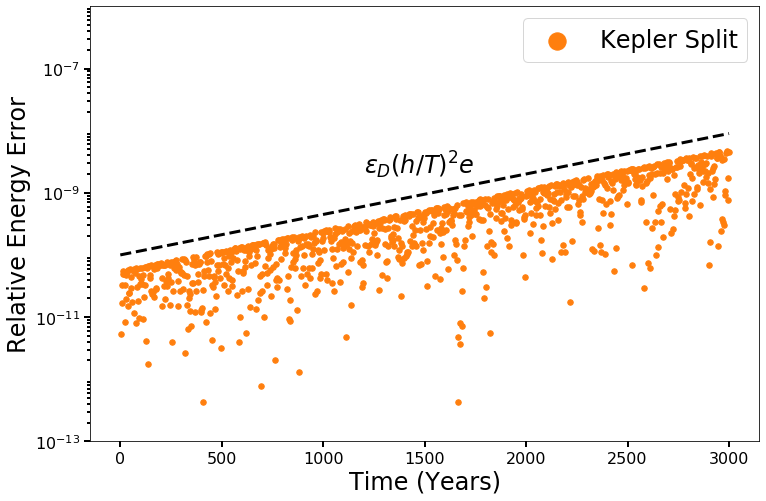

In [5]:
fig, ax = plt.subplots(figsize=(12,8))
s=30
#ax.scatter(times, np.abs((EsMIS-Es)/Es), s=s, label='Modified Integration Scheme')
ax.scatter(0,0) # dummy to keep color same
ax.scatter(times, np.abs((EsKD-Es)/Es), s=s, label='Kepler Split')
ax.plot(times, P/taua *(simKD.dt/P)**2 * e, 'k--')
ax.text(1200, 2.e-9, r'$\epsilon_D (h/T)^2e$', fontsize=24)
ax.set_yscale('log')
ax.set_ylabel('Relative Energy Error', fontsize=24)
ax.set_xlabel('Time (Years)', fontsize=24)
ax.set_ylim([1e-13, 1e-6])
lgnd = ax.legend(fontsize=24,loc='upper right', scatterpoints=1)
for handle in lgnd.legendHandles:
    handle.set_sizes([300])
plt.rcParams["text.usetex"] = False
plt.locator_params(axis='y', numticks=5)

fig.savefig("fig3.pdf", bbox_inches='tight')

In [130]:
%%time
Nout = 1000
e=0.1
dtOverT = 3.e-3
taua = 10
tmax = taua/1.5


simKD = makesim(e=e, dtOverT=dtOverT)
rebxKD = reboundx.Extras(simKD)
modKD = rebxKD.load_force("modify_orbits_forces")
rebxKD.add_force(modKD)

simKD.integrator = "none"
keplerKD = rebxKD.load_operator("kepler")
integforceKD = rebxKD.load_operator("integrate_force")
integforceKD.params['force'] = modKD
integforceKD.params['integrator'] = reboundx.integrators["rk4"]
rebxKD.add_operator(keplerKD, dt_fraction=0.5, timing="post")
rebxKD.add_operator(integforceKD, dt_fraction=1., timing="post")
rebxKD.add_operator(keplerKD, dt_fraction=0.5, timing="post")
simKD.particles[1].params['tau_a'] = -taua*simKD.particles[1].P

sim = makesim(e=e, dtOverT=dtOverT)
sim.integrator = "ias15"
rebx = reboundx.Extras(sim)
mod = rebx.load_force("modify_orbits_forces")
rebx.add_force(mod)
sim.particles[1].params['tau_a'] = -taua*simKD.particles[1].P

EsKD, EsMIS, Es = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
P = np.zeros(Nout)
times = np.linspace(0, tmax*simKD.particles[1].P, Nout)

for i, time in enumerate(times):
    simKD = corrector3(simKD, keplerKD, integforceKD, simKD.dt) 
    simKD.integrate(time, exact_finish_time=0)
    simKD = corrector3inv(simKD, keplerKD, integforceKD, simKD.dt) 
    sim.integrate(simKD.steps_done*simKD.dt)
    simMIS.integrate(simKD.steps_done*simKD.dt)
    
    Es[i] = sim.calculate_energy()
    EsKD[i] = simKD.calculate_energy()
    EsMIS[i] = simMIS.calculate_energy()
    P[i] = sim.particles[1].P

CPU times: user 198 ms, sys: 3.88 ms, total: 202 ms
Wall time: 201 ms


In [131]:
%%time
simKD = makesim(e=e, dtOverT=dtOverT)
rebxKD = reboundx.Extras(simKD)
modKD = rebxKD.load_force("modify_orbits_forces")

simKD.integrator = "none"
keplerKD = rebxKD.load_operator("kepler")
integforceKD = rebxKD.load_operator("integrate_force")
integforceKD.params['force'] = modKD
integforceKD.params['integrator'] = reboundx.integrators["rk4"]
rebxKD.add_operator(keplerKD, dt_fraction=0.5, timing="post")
rebxKD.add_operator(integforceKD, dt_fraction=1., timing="post")
rebxKD.add_operator(keplerKD, dt_fraction=0.5, timing="post")
simKD.particles[1].params['tau_a'] = -taua*simKD.particles[1].P

EsKD2 = np.zeros(Nout)
times = np.linspace(0, tmax*simKD.particles[1].P, Nout)

for i, time in enumerate(times):
    simKD.integrate(time, exact_finish_time=0)
    EsKD2[i] = simKD.calculate_energy()

CPU times: user 13.4 ms, sys: 4.04 ms, total: 17.4 ms
Wall time: 15.3 ms


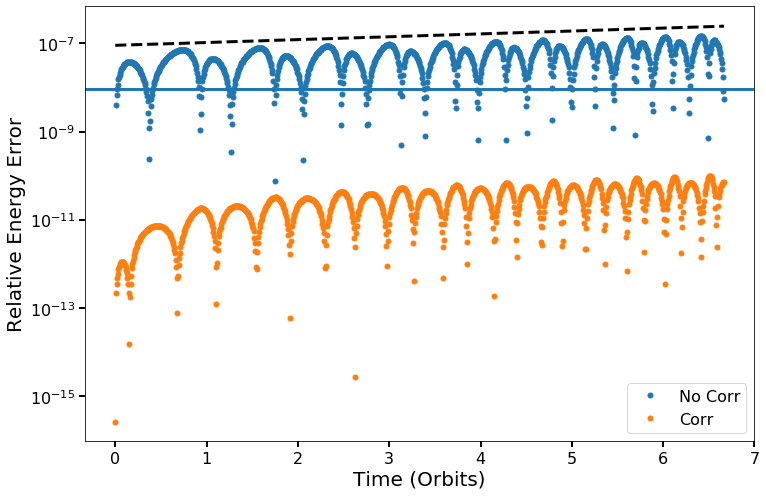

In [132]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(times, np.abs((EsKD2-Es)/Es), '.', label='No Corr')
ax.plot(times, np.abs((EsKD-Es)/Es), '.', label='Corr')
ax.plot(times, P/taua *(simKD.dt/P)**2 * e, 'k--')
ax.axhline((simKD.dt/taua)**2 * e)
#ax.text(600, 4.e-10, r'$\epsilon_D (h/T)^2e$', fontsize=24)
ax.set_yscale('log')
ax.set_ylabel('Relative Energy Error')
ax.set_xlabel('Time (Orbits)')
#ax.set_ylim([1e-13, 1e-9])
ax.legend()
#fig.savefig("fig3.pdf", bbox_inches='tight')

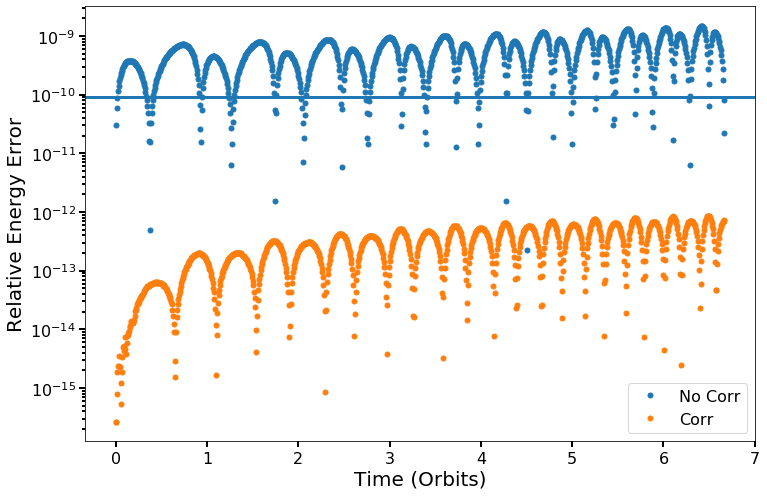

In [129]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(times, np.abs((EsKD2-Es)/Es), '.', label='No Corr')
ax.plot(times, np.abs((EsKD-Es)/Es), '.', label='Corr')
ax.axhline((simKD.dt/taua)**2 * e)
#ax.text(600, 4.e-10, r'$\epsilon_D (h/T)^2e$', fontsize=24)
ax.set_yscale('log')
ax.set_ylabel('Relative Energy Error')
ax.set_xlabel('Time (Orbits)')
#ax.set_ylim([1e-13, 1e-9])
ax.legend()
#fig.savefig("fig3.pdf", bbox_inches='tight')

In [64]:
P

array([1.        , 0.99798822, 0.99616907, 0.99436093, 0.99256538,
       0.99078393, 0.98901795, 0.98726872, 0.9855374 , 0.98382499,
       0.9821324 , 0.98046038, 0.97880953, 0.97718036, 0.97557323,
       0.97398836, 0.97242588, 0.97088581, 0.96936804, 0.9678724 ,
       0.96639861, 0.96494631, 0.96351509, 0.96210444, 0.96071382,
       0.95934263, 0.95799023, 0.95665594, 0.95533902, 0.95403874,
       0.95275433, 0.95148498, 0.9502299 , 0.94898825, 0.94775919,
       0.94654187, 0.94533544, 0.94413904, 0.9429518 , 0.94177285,
       0.94060131, 0.93943631, 0.93827697, 0.93712243, 0.93597179,
       0.9348242 , 0.93367876, 0.93253462, 0.93139088, 0.9302467 ,
       0.92910119, 0.92795349, 0.92680273, 0.92564807, 0.92448863,
       0.92332356, 0.92215203, 0.9209732 , 0.91978622, 0.91859028,
       0.91738458, 0.91616831, 0.91494071, 0.91370101, 0.91244849,
       0.91118244, 0.90990219, 0.90860712, 0.90729663, 0.9059702 ,
       0.90462735, 0.90326767, 0.90189083, 0.90049658, 0.89908